In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(root=r'/kaggle/input/pest-data/Testing_Data', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Calculate IoU for each class
    unique_classes = np.unique(y_true)
    iou_per_class = {}
    
    for cls in unique_classes:
        intersection = np.logical_and(y_pred == cls, y_true == cls).sum()
        union = np.logical_or(y_pred == cls, y_true == cls).sum()
        iou = intersection / union if union > 0 else 0
        iou_per_class[cls] = iou

    # Calculate mean IoU
    mean_iou = np.mean(list(iou_per_class.values()))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(unique_classes)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    y_true_binary = np.eye(n_classes)[y_true]
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, mean_iou, iou_per_class, fpr, tpr, roc_auc, cm

# Function to plot ROC curve for multiclass
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    for i in range(len(fpr) - 1):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (area = {roc_auc["micro"]:.2f})', color='darkorange', linestyle='--')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_{model_name}.png')  # Save ROC curve
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'confusion_matrix_{model_name}.png')  # Save confusion matrix
    plt.show()

# Function to evaluate model performance
def evaluate_model(model_path, test_loader, model_name, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = torch.load(model_path, map_location=device)
    model.eval()
    model = model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = nn.Softmax(dim=1)(outputs)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy, precision, recall, f1, mean_iou, iou_per_class, fpr, tpr, roc_auc, cm = calculate_metrics(
        all_labels, all_preds, all_probs
    )
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1 Score: {f1:.4f}, Mean IoU: {mean_iou:.4f}")
    
    # Print IoU for each class
    for cls, iou in iou_per_class.items():
        print(f"IoU for Class {cls}: {iou:.4f}")
    
    plot_roc_curve(fpr, tpr, roc_auc, model_name)
    plot_confusion_matrix(cm, class_names, model_name)

# Example usage
# evaluate_model('path_to_your_model.pth', test_loader, 'Model Name', class_names)

/tmp/ipykernel_94/4211292944.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


DenseNet201 - Accuracy: 0.9464, Precision: 0.9481, Recall: 0.9464, F1 Score: 0.9461, Mean IoU: 0.9036
IoU for Class 0: 0.8454
IoU for Class 1: 0.9075
IoU for Class 2: 0.8876
IoU for Class 3: 0.9490
IoU for Class 4: 0.9553
IoU for Class 5: 0.9023
IoU for Class 6: 0.9906
IoU for Class 7: 0.9406
IoU for Class 8: 0.9420
IoU for Class 9: 0.8608
IoU for Class 10: 0.9688
IoU for Class 11: 0.9731
IoU for Class 12: 0.7837
IoU for Class 13: 0.8811
IoU for Class 14: 0.8793
IoU for Class 15: 0.8850
IoU for Class 16: 0.7389
IoU for Class 17: 0.9276
IoU for Class 18: 0.9761
IoU for Class 19: 0.9165
IoU for Class 20: 0.9228
IoU for Class 21: 0.8445


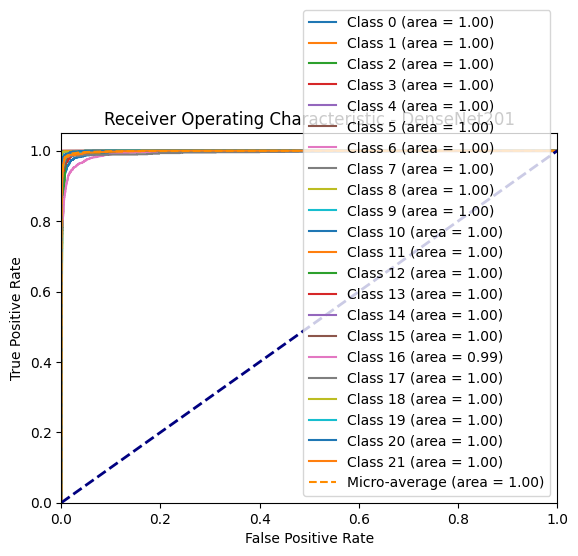

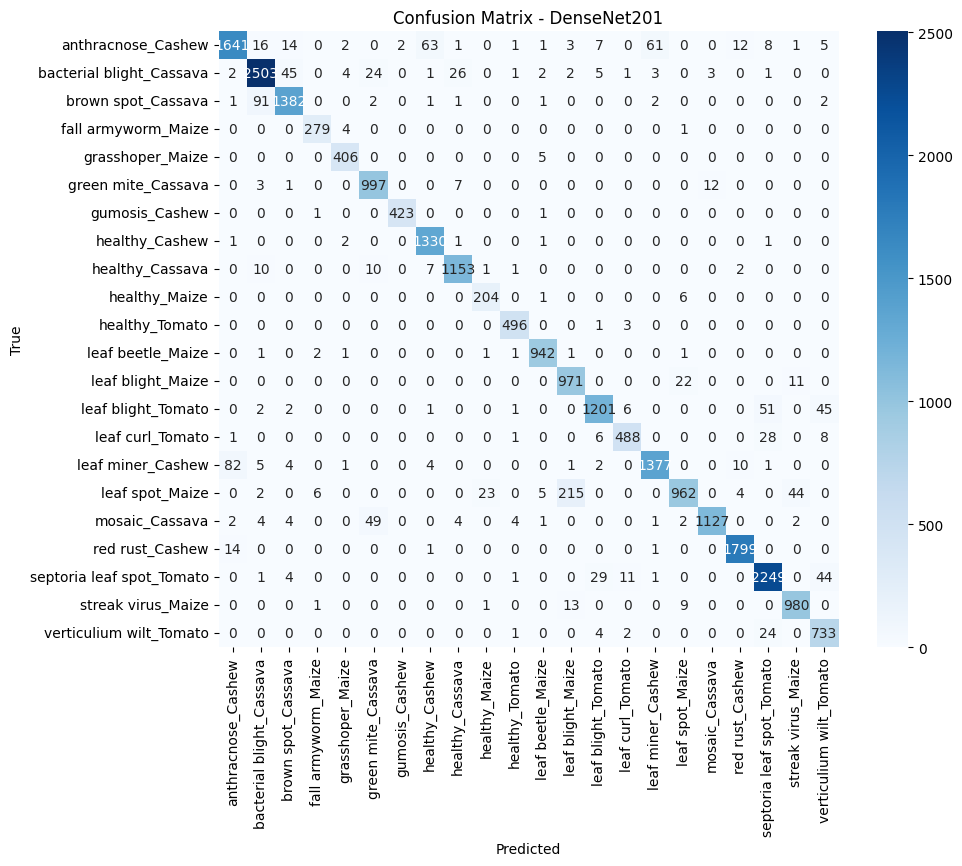

In [7]:
# class_names = test_dataset.classes
# evaluate_model("/kaggle/input/densenet201pure/pytorch/default/1/bestDensenet201.pth", test_loader, "DenseNet201", class_names)

In [10]:
print(torch.cuda.is_available())


models = {
    'DenseNet201+KAN':'/kaggle/input/models/other/default/1/best_model (1).pth',
    'CustomCNN+KAN':'/kaggle/input/models/other/default/1/kan_resnet18_ep41.pth',
    'DenseNet121': '/kaggle/input/models/other/default/1/model_den121.h5',
    'MobileNetV2': '/kaggle/input/models/other/default/1/model_mobv2.h5'
}
class_names = test_dataset.classes

# Evaluate each model
for model_name, model_path in models.items():
    evaluate_model(model_path, test_loader, model_name, class_names)

True


/tmp/ipykernel_94/4211292944.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


AttributeError: Can't get attribute 'DensenetKANModel' on <module '__main__'>